In [161]:
import numpy as np
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import itertools
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.cross_validation import  train_test_split
from sklearn.metrics import mean_squared_error
import sys
import math
import matplotlib
%matplotlib inline

In [162]:
# Gathered Apple Inc. quarterly revenue data from 2005-2018; used LSTM to model timeseries data and predict value for next quarter.
revenue= pd.read_csv('revenue4.csv')
revenue.head()

,Quarter (Fiscal year),Revenue (billions of US $) adjusted
0,Q4 2018,60.000
1,Q3 2018,53.265
2,Q2 2018,61.137
3,Q1 2018,88.293
4,Q4 2017,52.579


In [163]:
revenue=revenue.reindex(index=revenue.index[::-1])
revenue.columns= ['quarter', 'revenue']
revenue.head()

,quarter,revenue
55,Q1 2005,3.490
54,Q2 2005,3.243
53,Q3 2005,3.520
52,Q4 2005,3.678
51,Q1 2006,5.749


In [164]:
appl_revenue = revenue.revenue.values.astype('float32')
appl_revenue = appl_revenue.reshape(56, 1)
appl_revenue.shape


(56, 1)

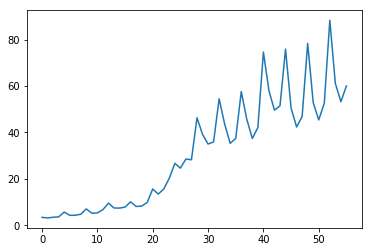

In [165]:
plt.plot(appl_revenue)

[1.] [0.]


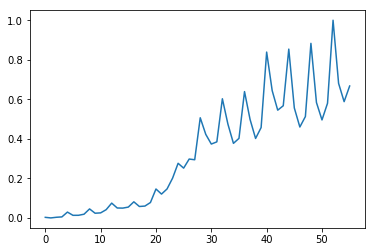

In [166]:
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
appl_revenue = scaler.fit_transform(appl_revenue)
plt.plot(appl_revenue)
print(max(appl_revenue),min(appl_revenue))

In [167]:
from pandas import DataFrame, datetime, concat

In [168]:
def new_data(data, lag=1):
    df= DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns,axis=1)
    df.fillna(0,inplace=True)
    return df

def create_dataset2(dataset):
    dataX= []
    a=dataset.values
    dataX.append(a[:,0])
    return np.array(dataX)


In [169]:
train_size = int(len(appl_revenue) * 0.8)
test_size = len(appl_revenue) - train_size

rev= new_data(appl_revenue, 1)
f=rev.values

x= create_dataset2(rev)
x=np.transpose(x)
trainX, testX = x[0:train_size,:], x[train_size:len(x),:]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
Y= f[:,1]
trainY= Y[0:train_size,]
testY= Y[train_size:len(Y),]
trainY.shape

(44,)

In [170]:
step_size=1
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [171]:
# Model compiling and fitting
model.compile(loss='mean_squared_error', optimizer='adagrad') 
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
 - 5s - loss: 0.0668
Epoch 2/20
 - 0s - loss: 0.0367
Epoch 3/20
 - 0s - loss: 0.0306
Epoch 4/20
 - 0s - loss: 0.0261
Epoch 5/20
 - 0s - loss: 0.0225
Epoch 6/20
 - 0s - loss: 0.0196
Epoch 7/20
 - 0s - loss: 0.0173
Epoch 8/20
 - 0s - loss: 0.0156
Epoch 9/20
 - 0s - loss: 0.0143
Epoch 10/20
 - 0s - loss: 0.0133
Epoch 11/20
 - 0s - loss: 0.0129
Epoch 12/20
 - 0s - loss: 0.0123
Epoch 13/20
 - 0s - loss: 0.0121
Epoch 14/20
 - 0s - loss: 0.0119
Epoch 15/20
 - 0s - loss: 0.0117
Epoch 16/20
 - 0s - loss: 0.0115
Epoch 17/20
 - 0s - loss: 0.0115
Epoch 18/20
 - 0s - loss: 0.0114
Epoch 19/20
 - 0s - loss: 0.0113
Epoch 20/20
 - 0s - loss: 0.0111


In [172]:
# Predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# DE-NORMALIZING for plotting
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Train RMSE: 8.85
Test RMSE: 21.16


In [173]:
# Creating dataset for train andtest predictions
trainPredictPlot = np.empty_like(appl_revenue)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [174]:
testPredictPlot = np.empty_like(appl_revenue)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict):len(appl_revenue), :] = testPredict

In [175]:
# DE-NORMALIZING Revenue
appl_revenue = scaler.inverse_transform(appl_revenue)

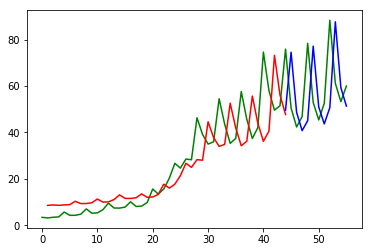

In [176]:
# Plot of original revenue along with training and test predictions
plt.plot(appl_revenue, 'g')
plt.plot(trainPredictPlot, 'r')
plt.plot(testPredictPlot, 'b')
plt.show()

In [177]:
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last quarter Value:", np.asscalar(last_val))
print("Next quarter Value:", np.asscalar(last_val*next_val))


Last quarter Value: 51.34568405151367
Next quarter Value: 50.944637298583984


In [178]:
# predicted q4 2018 revenue $50.94billion dollars meaning combined revenue for fiscal year 2018= $253.64 billion. According to applesrevenue guidance q4 2018 revenue expected to be around $62 billion , in hindsight maybe would have been better to use traditional timeseries modelling 